In [1]:
import os, time, copy
import pandas as pd, numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import albumentations as A
from albumentations.pytorch import ToTensorV2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [2]:
!unzip -q "/content/archive (5).zip" -d /content/dataset

In [3]:
class PrescriptionDataset(Dataset):
    def __init__(self, images_folder, label_file, label_to_id=None, transform=None):
        self.images_folder = images_folder
        self.df = pd.read_csv(label_file)
        self.df['IMAGE'] = self.df['IMAGE'].astype(str)
        self.df['MEDICINE_NAME'] = self.df['MEDICINE_NAME'].astype(str)

        if label_to_id is None:
            unique_labels = sorted(self.df['MEDICINE_NAME'].unique())
            self.label_to_id = {lbl: i for i, lbl in enumerate(unique_labels)}
        else:
            self.label_to_id = label_to_id

        self.df['label_id'] = self.df['MEDICINE_NAME'].map(self.label_to_id)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.images_folder, row['IMAGE'])
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(image=np.array(img))['image']
        label = int(row['label_id'])
        return img, label


In [4]:
train_images_folder = '/content/dataset/Doctor’s Handwritten Prescription BD dataset/Training/training_words'
train_label_file   = '/content/dataset/Doctor’s Handwritten Prescription BD dataset/Training/training_labels.csv'
val_images_folder  = '/content/dataset/Doctor’s Handwritten Prescription BD dataset/Validation/validation_words'
val_label_file     = '/content/dataset/Doctor’s Handwritten Prescription BD dataset/Validation/validation_labels.csv'
test_images_folder = '/content/dataset/Doctor’s Handwritten Prescription BD dataset/Testing/testing_words'
test_label_file    = '/content/dataset/Doctor’s Handwritten Prescription BD dataset/Testing/testing_labels.csv'

df_train = pd.read_csv(train_label_file)
unique_labels = sorted(df_train['MEDICINE_NAME'].astype(str).unique())
label_to_id = {lbl: i for i, lbl in enumerate(unique_labels)}
id_to_label = {i: lbl for lbl, i in label_to_id.items()}
num_classes = len(unique_labels)
print("Num classes:", num_classes)


Num classes: 78


In [5]:
train_transform = A.Compose([
    A.Resize(224, 224),
    A.Rotate(limit=15, p=0.7),
    A.Affine(translate_percent=0.05, scale=(0.9, 1.1), rotate=0, shear=0, p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussNoise(p=0.4),
    A.OneOf([
        A.MotionBlur(blur_limit=3, p=1.0),
        A.MedianBlur(blur_limit=3, p=1.0),
        A.Blur(blur_limit=3, p=1.0),
    ], p=0.3),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [6]:
# =========================
batch_size = 6
num_workers = 2

train_ds = PrescriptionDataset(train_images_folder, train_label_file, label_to_id, transform=train_transform)
val_ds   = PrescriptionDataset(val_images_folder, val_label_file, label_to_id, transform=val_test_transform)
test_ds  = PrescriptionDataset(test_images_folder, test_label_file, label_to_id, transform=val_test_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print("Train/Val/Test sizes:", len(train_ds), len(val_ds), len(test_ds))

Train/Val/Test sizes: 3120 780 780


In [7]:
class VGG16Baseline(nn.Module):
    def __init__(self, num_classes, pretrained=True, freeze_features=True):
        super().__init__()
        self.vgg = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1 if pretrained else None)
        if freeze_features:
            for param in self.vgg.features[:20].parameters():
                param.requires_grad = False
        in_features = self.vgg.classifier[6].in_features
        self.vgg.classifier[6] = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        return self.vgg(x)


In [8]:
def train_validate(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=36, save_path='best.pth'):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

    for epoch in range(num_epochs):
        model.train()
        running_loss, running_corrects, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
            total += inputs.size(0)
        epoch_loss = running_loss / total
        epoch_acc = running_corrects / total

        # Validation
        model.eval()
        val_loss, val_corrects, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data).item()
                val_total += inputs.size(0)
        val_epoch_loss = val_loss / val_total
        val_epoch_acc = val_corrects / val_total

        if scheduler:
            scheduler.step(val_epoch_loss)

        print(f"Epoch {epoch+1}/{num_epochs}  Train loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | Val loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}")

        history['train_loss'].append(epoch_loss)
        history['val_loss'].append(val_epoch_loss)
        history['train_acc'].append(epoch_acc)
        history['val_acc'].append(val_epoch_acc)

        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_path)
            print("  Saved best model.")

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model, history


In [9]:
def evaluate_and_report(model, loader, id_to_label, show_cm=True):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    acc = accuracy_score(y_true, y_pred)
    print("Test Accuracy: {:.4f}".format(acc))
    target_names = [id_to_label[i] for i in range(len(id_to_label))]
    print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))
    if show_cm:
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10,8))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.colorbar()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()
    return acc, y_true, y_pred

In [10]:
epochs = 36
model_name = 'vgg16_baseline_aug.pth'

model_vgg = VGG16Baseline(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vgg.parameters(), lr=5e-5, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


100%|██████████| 528M/528M [00:06<00:00, 82.3MB/s]


In [12]:
model_vgg, hist_vgg = train_validate(model_vgg, train_loader, val_loader,
                                     criterion, optimizer, scheduler=scheduler,
                                     num_epochs=epochs, save_path=model_name)


Epoch 1/36  Train loss: 4.3508 Acc: 0.0205 | Val loss: 4.2150 Acc: 0.0795
  Saved best model.
Epoch 2/36  Train loss: 4.0032 Acc: 0.0667 | Val loss: 3.0441 Acc: 0.2654
  Saved best model.
Epoch 3/36  Train loss: 2.7622 Acc: 0.2929 | Val loss: 1.1296 Acc: 0.7051
  Saved best model.
Epoch 4/36  Train loss: 1.4393 Acc: 0.5971 | Val loss: 0.5786 Acc: 0.8423
  Saved best model.
Epoch 5/36  Train loss: 0.8029 Acc: 0.7782 | Val loss: 0.3963 Acc: 0.8936
  Saved best model.
Epoch 6/36  Train loss: 0.5185 Acc: 0.8551 | Val loss: 0.2954 Acc: 0.9192
  Saved best model.
Epoch 7/36  Train loss: 0.3836 Acc: 0.8949 | Val loss: 0.3139 Acc: 0.9192
Epoch 8/36  Train loss: 0.2806 Acc: 0.9240 | Val loss: 0.2817 Acc: 0.9359
  Saved best model.
Epoch 9/36  Train loss: 0.2192 Acc: 0.9378 | Val loss: 0.2651 Acc: 0.9372
  Saved best model.
Epoch 10/36  Train loss: 0.1787 Acc: 0.9458 | Val loss: 0.3088 Acc: 0.9321
Epoch 11/36  Train loss: 0.1480 Acc: 0.9599 | Val loss: 0.2179 Acc: 0.9462
  Saved best model.
Epoc

Test Accuracy: 0.9077
              precision    recall  f1-score   support

         Ace       0.91      1.00      0.95        10
       Aceta       1.00      1.00      1.00        10
     Alatrol       1.00      0.90      0.95        10
      Amodis       1.00      1.00      1.00        10
     Atrizin       0.91      1.00      0.95        10
      Axodin       1.00      1.00      1.00        10
          Az       1.00      0.90      0.95        10
  Azithrocin       0.91      1.00      0.95        10
       Azyth       0.91      1.00      0.95        10
      Bacaid       0.91      1.00      0.95        10
    Backtone       1.00      1.00      1.00        10
    Baclofen       0.91      1.00      0.95        10
      Baclon       1.00      0.90      0.95        10
      Bacmax       0.91      1.00      0.95        10
       Beklo       1.00      0.90      0.95        10
     Bicozin       1.00      0.70      0.82        10
    Canazole       1.00      1.00      1.00        10
    C

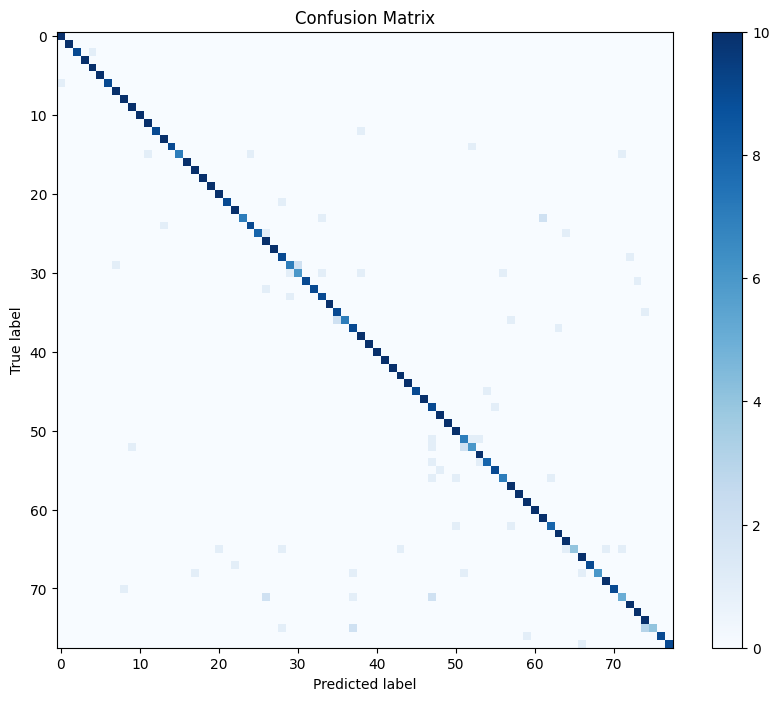

In [13]:
_ = evaluate_and_report(model_vgg, test_loader, id_to_label, show_cm=True)
